In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageFilter

In [2]:
table_data = pd.read_csv(r"F:\Semester 5\Manajemen Big Data\Final Project\Food Ingredients and Recipe Dataset with Image Name Mapping.csv")
table_data.head()

,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [3]:
table_data = table_data[:1000]
print('New shape after removing 12501 rows:', table_data.shape)

New shape after removing 12501 rows: (1000, 6)


# IMAGE

In [4]:
image_names = table_data['Image_Name'].unique()
print('Banyak nama gambar unik:', len(image_names))
print('10 Nama Gambar Pertama:', image_names[:10])

Banyak nama gambar unik: 1000
10 Nama Gambar Pertama: ['miso-butter-roast-chicken-acorn-squash-panzanella'
 'crispy-salt-and-pepper-potatoes-dan-kluger'
 'thanksgiving-mac-and-cheese-erick-williams'
 'italian-sausage-and-bread-stuffing-240559'
 'newtons-law-apple-bourbon-cocktail'
 'warm-comfort-tequila-chamomile-toddy' 'apples-and-oranges-spiked-cider'
 'turmeric-hot-toddy-claire-sprouse' 'instant-pot-lamb-haleem'
 'spiced-lentil-and-caramelized-onion-baked-eggs']


## Set Path

In [5]:
folder_path = r"F:\Semester 5\Manajemen Big Data\Final Project\Food Images\Food Images"
file_names = [os.path.splitext(f)[0] for f in os.listdir(folder_path)]

## Checking

In [6]:
image_names_set = set(table_data['Image_Name'].unique())
file_names_set = set(file_names)

matches = image_names_set & file_names_set
no_matches = image_names_set - file_names_set

In [7]:
print('Number of matches:', len(matches))
print('Number of no matches:', len(no_matches))
print('Total unique Image Names:', len(image_names_set))
print('Total files in folder:', len(file_names_set))

Number of matches: 1000
Number of no matches: 0
Total unique Image Names: 1000
Total files in folder: 13582


## Fungsi Prepo

Fungsi untuk memproses tiap gambar  
- Center Crop  
- Resize  
- Convert semua gambar ke RGB

In [8]:
def preprocess_image(image_path, processed_folder, image_name, resize_size=(256, 256), crop_size=(224, 224)):
    """
    Preprocess image: resize, center crop, and apply image sharpening, saving intermediate results.
    """
    try:
        with Image.open(image_path) as img:
            # konversi ke RGB
            # karena ada yang JPEG
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # resize
            img_resized = img.resize(resize_size, Image.Resampling.LANCZOS)
            
            # save hasil resized
            resized_path = os.path.join(processed_folder, 'resized', image_name + '.jpg')
            os.makedirs(os.path.dirname(resized_path), exist_ok=True)
            img_resized.save(resized_path)
            
            # center crop
            width, height = img_resized.size
            crop_width, crop_height = crop_size
            left = (width - crop_width) // 2
            top = (height - crop_height) // 2
            right = left + crop_width
            bottom = top + crop_height
            img_cropped = img_resized.crop((left, top, right, bottom))
            
            # save hasil cropped
            cropped_path = os.path.join(processed_folder, 'cropped', image_name + '.jpg')
            os.makedirs(os.path.dirname(cropped_path), exist_ok=True)
            img_cropped.save(cropped_path)
            
            # image sharpening
            img_sharpened = img_cropped.filter(ImageFilter.SHARPEN)
            
            # save hasil sharpened
            sharpened_path = os.path.join(processed_folder, 'sharpened', image_name + '.jpg')
            os.makedirs(os.path.dirname(sharpened_path), exist_ok=True)
            img_sharpened.save(sharpened_path)
            
            return True
    except Exception as e:
        print(f"Error {image_path}: {e}")
        return False

## Set Path Tujuan

In [9]:
# path tujuan
processed_folder = r"F:\Semester 5\Manajemen Big Data\Final Project\Processed Images"
os.makedirs(processed_folder, exist_ok=True)

# buat subfolder untuk setiap langkah
os.makedirs(os.path.join(processed_folder, 'cropped'), exist_ok=True)
os.makedirs(os.path.join(processed_folder, 'resized'), exist_ok=True)
os.makedirs(os.path.join(processed_folder, 'sharpened'), exist_ok=True)

## Pipeline

In [10]:
def run_preprocessing_pipeline(table_data, image_folder, processed_folder):
    success_count = 0
    total = len(table_data)
    for idx, row in table_data.iterrows():
        image_name = row['Image_Name']
        image_path = os.path.join(image_folder, image_name + '.jpg')
        
        if os.path.exists(image_path):
            if preprocess_image(image_path, processed_folder, image_name):
                success_count += 1
        else:
            print(f"Image not found: {image_path}")
    
    print(f"Preprocessing completed. {success_count}/{total} images processed successfully.")

In [11]:
# Run the pipeline
image_folder = r"F:\Semester 5\Manajemen Big Data\Final Project\Food Images\Food Images"
run_preprocessing_pipeline(table_data, image_folder, processed_folder)

Preprocessing completed. 1000/1000 images processed successfully.


## Tampilkan Hasil Akhir

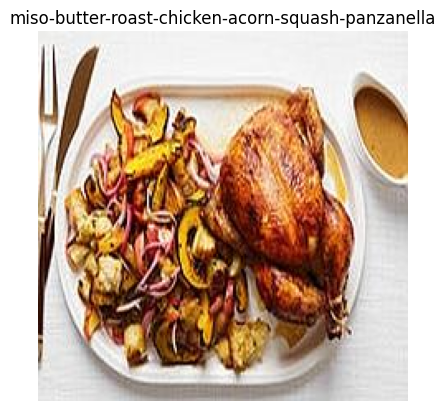

(224, 224, 3)


In [12]:
# pilih gambar pertama hasil prepo terakhir
first_image_name = table_data['Image_Name'].iloc[0]
sharpened_image_path = os.path.join(processed_folder, 'sharpened', first_image_name + '.jpg')

# Load gambar sharpened
img_sharpened = Image.open(sharpened_image_path)

# Convert ke numpy array untuk mendapatkan shape
img_array = np.array(img_sharpened)

# Tampilkan gambar
plt.imshow(img_sharpened)
plt.title(f'{first_image_name}')
plt.axis('off')
plt.show()

# shape
print(img_array.shape)

In [13]:
print(img_array)

[[[237 237 235]
  [237 237 235]
  [236 236 234]
  ...
  [236 236 236]
  [237 237 237]
  [237 237 237]]

 [[237 237 235]
  [236 236 234]
  [236 236 234]
  ...
  [236 236 236]
  [236 236 236]
  [237 237 237]]

 [[236 236 234]
  [236 236 234]
  [236 236 234]
  ...
  [233 233 233]
  [233 233 233]
  [234 234 234]]

 ...

 [[232 232 232]
  [233 233 233]
  [233 233 233]
  ...
  [223 223 223]
  [222 222 222]
  [221 221 221]]

 [[232 232 232]
  [233 233 233]
  [233 233 233]
  ...
  [229 229 229]
  [227 227 227]
  [227 227 227]]

 [[227 227 227]
  [228 228 228]
  [229 229 229]
  ...
  [226 226 226]
  [224 224 224]
  [223 223 223]]]


## Lima Gambar Pertama

In [ ]:
# Ambil beberapa gambar pertama (misalnya 5) dari table_data
num_samples = 5
image_names = table_data['Image_Name'].head(num_samples).tolist()

# List untuk menyimpan flattened array dari setiap gambar sharpened yang dinormalisasi
data = []

for name in image_names:
    sharpened_path = os.path.join(processed_folder, 'sharpened', name + '.jpg')
    img = Image.open(sharpened_path)
    img_array = np.array(img)
    
    # Normalisasi: skala ke [0,1]
    img_normalized = img_array / 255.0
    
    # Tampilkan array hasil normalisasi (sebagian saja)
    print(f"Array hasil normalisasi untuk {name} (shape: {img_normalized.shape}):")
    print(img_normalized[:5, :5, :])  # sebagian
    
    # Flatten array yang dinormalisasi
    flattened = img_normalized.flatten()
    data.append(flattened)

# Buat DataFrame
df_images = pd.DataFrame(data, index=image_names)

# Tampilkan DataFrame 
print(df_images)

Array hasil normalisasi untuk miso-butter-roast-chicken-acorn-squash-panzanella (shape: (224, 224, 3)):
[[[0.92941176 0.92941176 0.92156863]
  [0.92941176 0.92941176 0.92156863]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.92941176 0.92941176 0.92156863]]

 [[0.92941176 0.92941176 0.92156863]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.92941176 0.92941176 0.92156863]]

 [[0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]]

 [[0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.92941176 0.92941176 0.92156863]]

 [[0.9254902  0.9254902  0.91764706]
  [0.9254902  0.9254902  0.91764706]
  [0.92941176 0.92941176 0.92156863]
  [0.92941176 0.92941176 0.92156863]


## Gambar Terakhir

In [ ]:
# Ambil gambar terakhir dari table_data
last_image_name = table_data['Image_Name'].iloc[-1]
sharpened_path = os.path.join(processed_folder, 'sharpened', last_image_name + '.jpg')

# Load gambar sharpened
img = Image.open(sharpened_path)
img_array = np.array(img)

# Normalisasi: skala ke [0,1]
img_normalized = img_array / 255.0

# Tampilkan array hasil normalisasi 
print(f"Array hasil normalisasi untuk {last_image_name} (shape: {img_normalized.shape}):")
print(img_normalized[:5, :5, :])  # sebagian

# Flatten array yang dinormalisasi
flattened = img_normalized.flatten()

# Buat DataFrame
df_images = pd.DataFrame([flattened], index=[last_image_name])

# Tampilkan DataFrame
print(df_images)

Array hasil normalisasi untuk sunday-stash-sweet-potatoes (shape: (224, 224, 3)):
[[[0.87058824 0.85490196 0.85098039]
  [0.87058824 0.85490196 0.85098039]
  [0.87058824 0.85490196 0.85882353]
  [0.87058824 0.85490196 0.85882353]
  [0.87058824 0.85490196 0.85882353]]

 [[0.87058824 0.85490196 0.85098039]
  [0.87058824 0.85490196 0.85098039]
  [0.87058824 0.85490196 0.85882353]
  [0.87058824 0.85490196 0.85882353]
  [0.87058824 0.85490196 0.85882353]]

 [[0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.85490196]]

 [[0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.84705882]
  [0.86666667 0.85098039 0.85490196]]

 [[0.87058824 0.85098039 0.83921569]
  [0.87058824 0.85098039 0.83921569]
  [0.87058824 0.85098039 0.83921569]
  [0.87058824 0.85098039 0.83921569]
  [0.86666667 0.850980